<a href="https://colab.research.google.com/github/AliBenovaa/IANNwTF_Group24/blob/main/Homework03Group24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

#split the data in testing and training 
( train_ds , test_ds ) , ds_info = tfds . load ('mnist' , split =[ 'train','test'], as_supervised = True , with_info = True )

#Exercise 2.1

#How many training/test images are there?
#There are 60000 training images and 10000 test images
#'test': <SplitInfo num_examples=10000, num_shards=1>,
#'train': <SplitInfo num_examples=60000, num_shards=1>


#What's the image shape? 
# 28,28,1
#'image': Image(shape=(28, 28, 1), dtype=tf.uint8)

#What range are pixel values in? 
# from zero to 255 

#load the data
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

#get the data ready to be used
def data_pipeline(mnist):
  #change datatype from unint8 to tf.float values 
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #flatten the 28x28 images 
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)
  #return preprocessed dataset
  return mnist

train_dataset = train_ds.apply(data_pipeline)
test_dataset = test_ds.apply(data_pipeline)




Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [2]:
#2.3 Builidng a deep neural network 

class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        #define two hidden layers with 256 units each + activation function relu
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)#input layer
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out =tf.keras.layers.Dense(10, activation=tf.nn.softmax)#output layer

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.out(x)
        return x

In [3]:
#2.4 Training the network

#define our hyperparameters
num_epochs = 10
learning_rate = 0.1

model = MyModel()
# Initialize the loss: categorical cross entropy. 
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters.
optimizer = tf.keras.optimizers.SGD(learning_rate)


#we define the train step function and the test one
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test_step(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (inputs, target) in test_data:
    prediction = model(inputs)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy


#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)


In [4]:
# define empty lists 
train_losses = []
test_losses = []
test_accuracies = []

test_loss,test_accuracy = test_step(model,test_dataset,cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss,_= test_step(model,train_dataset,cross_entropy_loss)
train_losses.append(train_loss)

# we put everything together with a for loop that foes through the whole network
def training(num_epochs, model, train_dataset, test_dataset, cross_entropy_loss, optimizer, train_losses, test_losses, test_accuracies):

  #We train for num_epochs epochs.
  for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []

    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer) #call the train step
        epoch_loss_agg.append(train_loss)

      #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test_step(model, test_dataset, cross_entropy_loss)#call the test step
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

  return train_losses,test_losses,test_accuracies

Epoch: 0 starting with accuracy 0.1028125
Epoch: 1 starting with accuracy 0.9228125
Epoch: 2 starting with accuracy 0.946875
Epoch: 3 starting with accuracy 0.9509375
Epoch: 4 starting with accuracy 0.9615625
Epoch: 5 starting with accuracy 0.9590625
Epoch: 6 starting with accuracy 0.97
Epoch: 7 starting with accuracy 0.965625
Epoch: 8 starting with accuracy 0.9721875
Epoch: 9 starting with accuracy 0.9684375


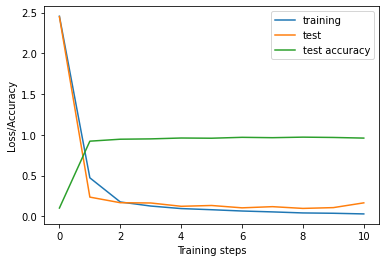

In [5]:
#we fill the lists with the new values 
train_losses, test_losses, test_accuracies = training(num_epochs, model, train_dataset, test_dataset, cross_entropy_loss, optimizer, train_losses, test_losses, test_accuracies)

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test","test accuracy"))
plt.show()